In [61]:
%matplotlib inline
import glob
import matplotlib
import matplotlib.pylab as plt
plt.style.use('ggplot')
matplotlib.rc('image', origin='lower', cmap='magma')
matplotlib.rc('axes', grid=False)
import numpy as np
import astropy.io.fits as fits
import IPython.html.widgets as widgets
import pandas as pd
from os.path import basename
from astropy.nddata.utils import Cutout2D

# Applications of PCA to astronomy

  - We have already seen how to decompose quasar spectra with a controlled loss of information
    - Generalize the function of (x, y) above to a 1D vector (x_1, x_2, ..., x_n) with fluxes in each wavelength bin.
  - The world of high-contrast exoplanet imaging *loves* PCA

# High-contrast imaging

We look for planets around stars other than the sun. Unfortunately, the starlight outshines thermal planet emission (think Earth's IR glow around 14ºC -- 10 microns) and reflected light (think the "pale blue dot") by many orders of magnitude.

<table>
  <tr><th>Observatory</th>   <th>Instrument</th>           <th>Contrast ratio</th><th>Contrast (magnitudes)</th></tr>
  <tr><td>ESO VLT</td>       <td>SHPERE</td>               <td>&approx; 10<sup>5</sup></td><td>12.5</td></tr>
  <tr><td>Gemini South</td>  <td>Gemini Planet Imager</td> <td>&approx; 10<sup>6</sup></td><td>15</td></tr>
  <tr><td>Magellan Clay</td> <td>Clio + vAPP</td>          <td>&approx; 10<sup>5</sup> &ndash; 10<sup>6</sup></td><td>12.5 - 15</td></tr>
</table>

("What kind of magnitude is that? What affects the range?" you may ask. Great question. Let's move on.)

# PSF Subtraction

Two terms you will hear a lot in high-contrast imaging are:

  * "starlight suppression" — typically referring to optics that extinguish stellar light in a region while leaving nearby sources visible
  * "PSF (point-spread function) subtraction" — using data analysis techniques to model residual starlight and subtract it while not removing nearby sources

In order to subtract the PSF, you must first have an idea of the flux pattern that characterizes it. Since we're all astronomers, it should be safe to skip the usual definition of a point source diffraction pattern and why you might want to model it.

Suffice to say, given a bunch of example point source images, principal component analysis does a great job of capturing overall PSF intensity pattern information.

Furthermore, the ability to truncate the PCA expansion by specifying a number of components means that we can create a model PSF that excludes small image-to-image variations.

# How do you do PCA of an _image_?

Images are 2D! Do we need to generalize PCA to higher dimensions?

Trick question, we already have. A 1000+ element spectrum is a vector in $\mathbb{R}^{1000+}$.

So, the way to decompose an $80 \times 80$ pixel image? *Just flatten it into a 6400 element vector!*

![flattening an image](https://user-images.githubusercontent.com/31168267/33640149-0fc50c24-d9ec-11e7-9a75-ec8e52f6b6f7.png)

# PCA doesn't care about spatial adjacency of quantities represented by feature vector elements

Which, it turns out, is fine. This is information that could, in theory, be used in computing a model PSF (e.g. by penalizing fits that lead to "sharp" pixel-to-pixel variations). In practice, PCA (KLIP) works so darn well that we don't bother.

# Would you like to see a somewhat simplistic example?

*Of course you would!*

To actually reduce high contrast imaging data, you will need to worry about the parameters of the instrument and the particulars of the target and observation. Ryan, Minghao, and Sam will all discuss Gemini Planet Imager data. It's a state of the art instrument, and comes with some serious software for manipulating its outputs.

In the interests of showing you how you'd build such a software pipeline, I'm going to use data from 1997's foremost spaceborne high-contrast imaging facility: NICMOS!

<div style="width: 50%; margin: 0 auto;">
<img alt="NICMOS technical drawing from NASA/ESA" src="./figures/joseph/nicmos_1.jpg">
</div>

# NICMOS is dead, long live NICMOS!

The Near Infrared Camera and Multi-Object Spectrometer was installed on Hubble in 1997. It was switched off after problems with the cooling system forced NASA to decide between a risky recovery operation for one instrument or many years of continued science with the others. (Officially, it operated from 1997-1999 and from 2002-2008.)

Being a near infrared instrument, there was obviously great interest in imaging exoplanets and debris disks with it. Being a space observatory, the PSF was exsquisitely stable (compared to ground-based observatories, which have to contend with AO control lag at best and atmospheric turbulence at worst).

Steward Observatory's own Glenn Schneider led a program, **[LAPLACE](https://archive.stsci.edu/prepds/laplace/)**, to provide high-level recalibrated images from the NICMOS archive. Bad pixels have been interpolated over, the (considerable) variable dark current has been subtracted, and the images can be tossed into your analysis code almost as-is.

(In fact, the [ALICE Hubble Archival program](https://archive.stsci.edu/prepds/alice/) did just that.)

I've gone ahead and downloaded about 1300 images of the LAPLACE DD1 "contemporary flats" archive and sliced them up to create $80 \times 80$ pixel postage stamps for analysis.

The `./data/laplace/nicmos_f160w_psf_ref.fits` file contains those images that contained well-centered point sources in the F160W bandpass and `NIC2-CORON` coronagraphic aperture configuration.

The `./data/laplace/nicmos_f160w_data.fits` file contains the data in the PSF reference file, plus extended and multiple source images.

(Details are in the [NICMOS Data Retrieval](./NICMOS Data Retrieval.ipynb) and [Construct NICMOS PSF cubes](./Construct NICMOS PSF cubes.ipynb) notebooks.)

In [110]:
psfs = fits.open('./data/laplace/nicmos_f160w_psf_ref.fits')
psf_datacube = psfs[1].data
images = fits.open('./data/laplace/nicmos_f160w_data.fits')
images_datacube = images[1].data

In the interests of simplifying the code, we've thrown out some of the image information (e.g. headers, subframe coordinates) to fit the data into homogeneous cubes. Here's what we've got for PSF reference data in F160W:

In [111]:
psf_datacube.shape

(558, 80, 80)

And for all images (including those reference PSFs):

In [112]:
images_datacube.shape

(702, 80, 80)

Let's see what our PSFs look like:

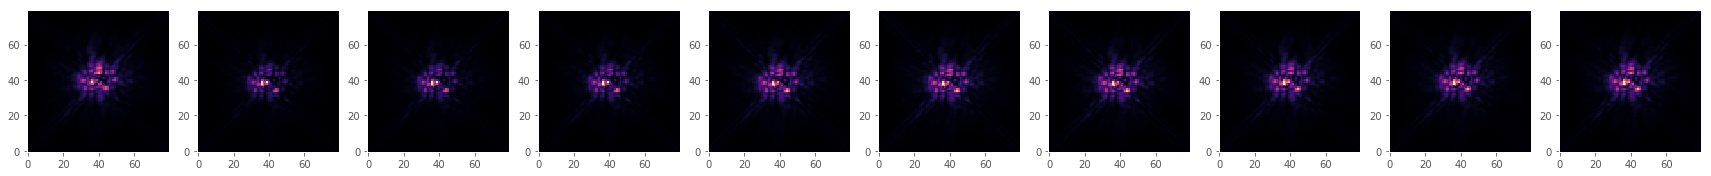

In [113]:
sample_count = 10
sample_start = 100
plt.figure(figsize=(3 * sample_count, 3))
for i in range(1, sample_count + 1):
    plt.subplot(1, 10, i)
    plt.imshow(psf_datacube[sample_start + i])

# Do `scikit-learn` to it

As we have seen, `scikit-learn` has implementations of common data decomposition algorithms—including PCA.

In [114]:
from sklearn import decomposition

We select a number of components to "learn" from the `psf_datacube`:

In [115]:
n_components = 6

In [116]:
pca_fit = decomposition.PCA(n_components=n_components)

Note that the `PCA.fit` method wants a flattened image, as we showed above. Fortunately, NumPy lets us reshape our datacube in place: 

In [117]:
zz, yy, xx = psf_datacube.shape
flattened_psfs = psf_datacube.reshape((zz, yy * xx))
flattened_psfs.shape

(558, 6400)

We can even visualize the set of 558 new $\mathbb{R}^{6400}$ vectors as an image:

In [118]:
vmin, vmax = (np.percentile(flattened_psfs, 5),
              np.percentile(flattened_psfs, 95))

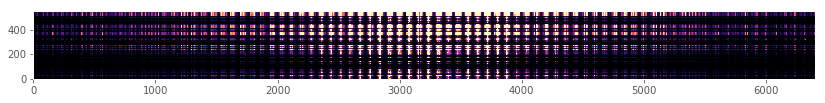

In [119]:
plt.figure(figsize=(14, 4))
plt.imshow(flattened_psfs, vmin=vmin, vmax=vmax)

## Compute the principal components:

In [120]:
pca_fit = pca_fit.fit(flattened_psfs)

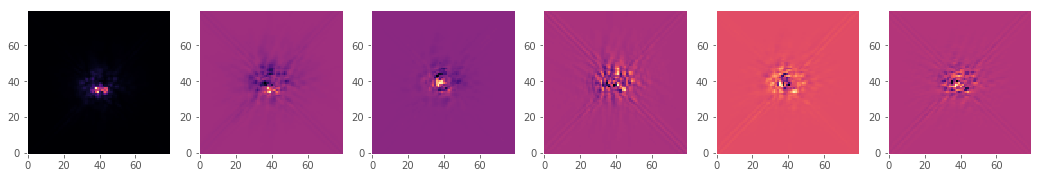

In [121]:
plt.figure(figsize=(3 * n_components, 3))
for i in range(n_components):
    plt.subplot(1, n_components, i + 1)
    plt.imshow(pca_fit.components_[i].reshape(psf_datacube[0].shape))

# Now, to do a PSF subtraction...

Coronagraphers (is that what we call them?) rarely demonstrate their optics or algorithms on "interesting" sources. An image of total starlight suppression would make them very excited, and look like noise to us.

To experience this excitement for ourselves, let us use PCA to model a PSF.

1. Transform the image to the basis defined by the PCA decomposition ($\mathbb{R}^{6400} \rightarrow \mathbb{R}^{6}$)
2. Create a model PSF from the component coefficients and component vectors ($\mathbb{R}^{6} \rightarrow \mathbb{R}^{6400}$)
3. Subtract this model PSF from the original image

In [191]:
# Step 1.
image = psf_datacube[70]
components = pca_fit.transform([image.flatten(),])
# Step 2.
model = pca_fit.inverse_transform(components)
model = model[0].reshape(image.shape)
# Step 3.
difference = image - model

**That's it.**

Aren't free, open-source libraries wonderful? Remember to donate to NumFOCUS and take a deduction on your taxes.

## Visualize the residuals

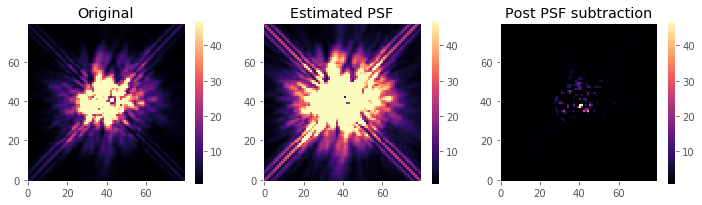

In [192]:
vmin, vmax = np.percentile(image, 5), np.percentile(image, 95)
plt.figure(figsize=(12, 3))
plt.subplot(1,3,1)
plt.imshow(image, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title('Original')
plt.subplot(1,3,2)
plt.imshow(psf_estimate, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title('Estimated PSF')
plt.subplot(1,3,3)
plt.imshow(difference, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title('Post PSF subtraction')

As we had hoped, more of the residual starlight is removed, improving our chances of finding planets at smaller separations from the star.

# The Unreasonable Effectiveness of PCA in the Natural Sciences

While preparing this talk, I picked a random plane of the data cube as my "this will show a complete subtraction" example.

To my great surprise, it turned out to show a circumstellar disk.

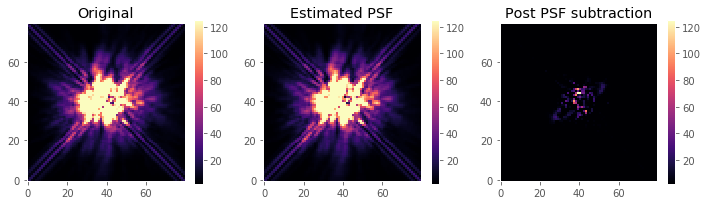

In [170]:
# Step 1.
image = psf_datacube[298]
components = pca_fit.transform([image.flatten(),])
# Step 2.
model = pca_fit.inverse_transform(components)
model = model[0].reshape(image.shape)
# Step 3.
difference = image - model

vmin, vmax = np.percentile(image, 5), np.percentile(image, 95)
plt.figure(figsize=(12, 3))
plt.subplot(1,3,1)
plt.imshow(image, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title('Original')
plt.subplot(1,3,2)
plt.imshow(psf_estimate, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title('Estimated PSF')
plt.subplot(1,3,3)
plt.imshow(difference, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title('Post PSF subtraction')

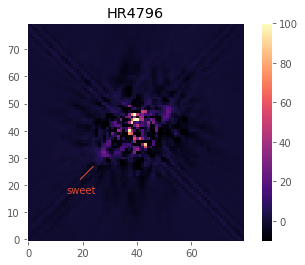

In [172]:
plt.imshow(difference, vmin=-10, vmax=100)
plt.colorbar()
plt.title('HR4796')
plt.arrow(24, 27, -5, -5, color='C0')
plt.text(24-10, 27-10, 'sweet', color='C0')

In [84]:
images[2].data[images[2].data['TARGTYPE'] == 'EXTENDED_SOURCE']

FITS_rec([ (1, 'F160W', 58.259911000000002, 'NO', 'NO', 'OK', 'CENTERED', 'EXTENDED_SOURCE', './data/laplace/dd1/contemp_flats_repaired/n4nl52iaq_clc_calf.fits'),
       (65, 'F160W', 58.259911000000002, 'NO', 'NO', 'OK', 'CENTERED', 'EXTENDED_SOURCE', './data/laplace/dd1/contemp_flats_repaired/n4nl52ifq_clc_calf.fits'),
       (67, 'F160W', 58.259911000000002, 'NO', 'NO', 'OK', 'CENTERED', 'EXTENDED_SOURCE', './data/laplace/dd1/contemp_flats_repaired/n4nl52i3q_clc_calf.fits'),
       (74, 'F160W', 58.259911000000002, 'NO', 'NO', 'OK', 'CENTERED', 'EXTENDED_SOURCE', './data/laplace/dd1/contemp_flats_repaired/n4nl52i9q_clc_calf.fits'),
       (108, 'F160W', 173.212997, 'NO', 'NO', 'OK', 'CENTERED', 'EXTENDED_SOURCE', './data/laplace/dd1/contemp_flats_repaired/n4fh08ziq_clc_calf.fits'),
       (111, 'F160W', 331.15609699999999, 'NO', 'NO', 'OK', 'CENTERED', 'EXTENDED_SOURCE', './data/laplace/dd1/contemp_flats_repaired/n4fh04drq_clc_calf.fits'),
       (161, 'F160W', 58.259911000000002, '

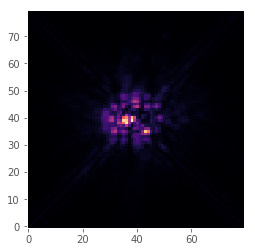

In [42]:
plt.imshow(images_datacube[64])

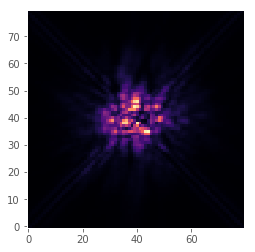

In [43]:
plt.imshow(images_datacube[63])

In [79]:
image = psf_datacube[0]

In [126]:
psfs[2].data[0]

(33, 'NIC2-CORON', 54.539055555559997, 'F160W', 173.16360499999999, 'NO', 'NO', 'OK', 177.8683333333, 'CENTERED', 'PG1148+5454-PSF', 'POINT_SOURCE', './data/laplace/dd1/contemp_flats_repaired/n4fha8zvq_clc_calf.fits')

In [129]:
fn = './data/laplace/dd1/contemp_flats_repaired/n4q890hyq_clc_calf.fits'
np.where(psfs[2].data['filename'] == fn)

(array([298]),)

In [125]:
psfs[2].data[0]

(33, 'NIC2-CORON', 54.539055555559997, 'F160W', 173.16360499999999, 'NO', 'NO', 'OK', 177.8683333333, 'CENTERED', 'PG1148+5454-PSF', 'POINT_SOURCE', './data/laplace/dd1/contemp_flats_repaired/n4fha8zvq_clc_calf.fits')

In [86]:
fits.getheader('./data/laplace/dd1/contemp_flats_repaired/n4q890hyq_clc_calf.fits')

SIMPLE  =                    T /image conforms to FITS standard                 
BITPIX  =                    8 /bits per data value                             
NAXIS   =                    0 /number of axes                                  
EXTEND  =                    T /file may contain extensions                     
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
IRAF-TLM= '2010-04-21T05:10:07' / Time of last modification                     
NEXTEND =                    5 / Number of standard extensions                  
DATE    = '2010-04-21T05:10:07' / date this file was written (yyyy-mm-dd)       
FILENAME= 'n4q890hyq_clc_cal.fits' / name of file                               
FILETYPE= 'SCI      '          / type of data found in data file                
                                                                                
TELESCOP= 'HST'                / telescope used to acquire data                 
INSTRUME= 'NICMOS'          

In [81]:
components = pca_fit.transform([image.flatten(),])

In [82]:
psf_estimate = pca_fit.inverse_transform(components)
# Convert from (1, 6400) to (80, 80)
psf_estimate = psf_estimate.reshape(image.shape)

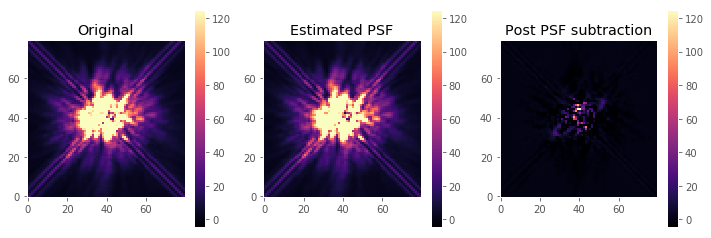

In [83]:
difference = image - psf_estimate
vmin, vmax = np.percentile(difference, 5), np.percentile(image, 95)
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
plt.imshow(image, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title('Original')
plt.subplot(1,3,2)
plt.imshow(psf_estimate, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title('Estimated PSF')
plt.subplot(1,3,3)
plt.imshow(difference, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title('Post PSF subtraction')